In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from networks import *

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
import cv2

from make_data import RandCirc

# Let Keras know that we are using tensorflow as our backend engine
os.environ["KERAS_BACKEND"] = "tensorflow"
# To make sure that we can reproduce the experiment and get the same results
np.random.seed(10)
# The dimension of our random noise vector.
# random_dim = 100

In [2]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan


def show_stacked_images(images, epoch=1, rows=10, cols=10):
    # make the matrix of images to show in opencv
    # images = images.reshape(100, 28, 28)
    assert (len(images) >= int(rows * cols))
    im = np.array([])
    im_rows = np.array([])
    num = 0
    for i in range(rows):
        for j in range(cols):
            if im_rows.any():
                im_rows = np.concatenate((im_rows, images[num]), axis=1)
            else:
                im_rows = images[num]
            num += 1
        # cv2.imshow('row1', im_rows)
        # cv2.waitKey()
        if im.any():
            im = np.concatenate((im, im_rows), axis=0)
        else:
            im = im_rows
        im_rows = np.array([])
    cv2.imshow(f'epoch {epoch}', im)
    cv2.waitKey(10)


def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(20, 20)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 100, 100)
    # show_stacked_images(generated_images, epoch)
    if epoch == 1 or epoch % 10 == 0:
        plt.figure(figsize=figsize)
        for i in range(generated_images.shape[0]):
            plt.subplot(dim[0], dim[1], i+1)
            plt.imshow(generated_images[i],
                       interpolation='nearest', cmap='gray_r')
            plt.axis('off')
        plt.tight_layout()
        plt.savefig('saves/gan_generated_image_epoch_%d.png' % epoch)
        # plt.show() # тут все замирает


x_train shape = (10000, 10000)


C:\Python39\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


--------------- Epoch 1 ---------------


100%|██████████| 78/78 [00:14<00:00,  5.21it/s]


--------------- Epoch 2 ---------------


100%|██████████| 78/78 [00:13<00:00,  5.63it/s]


--------------- Epoch 3 ---------------


100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


--------------- Epoch 4 ---------------


 10%|█         | 8/78 [00:01<00:17,  4.05it/s]


KeyboardInterrupt: 

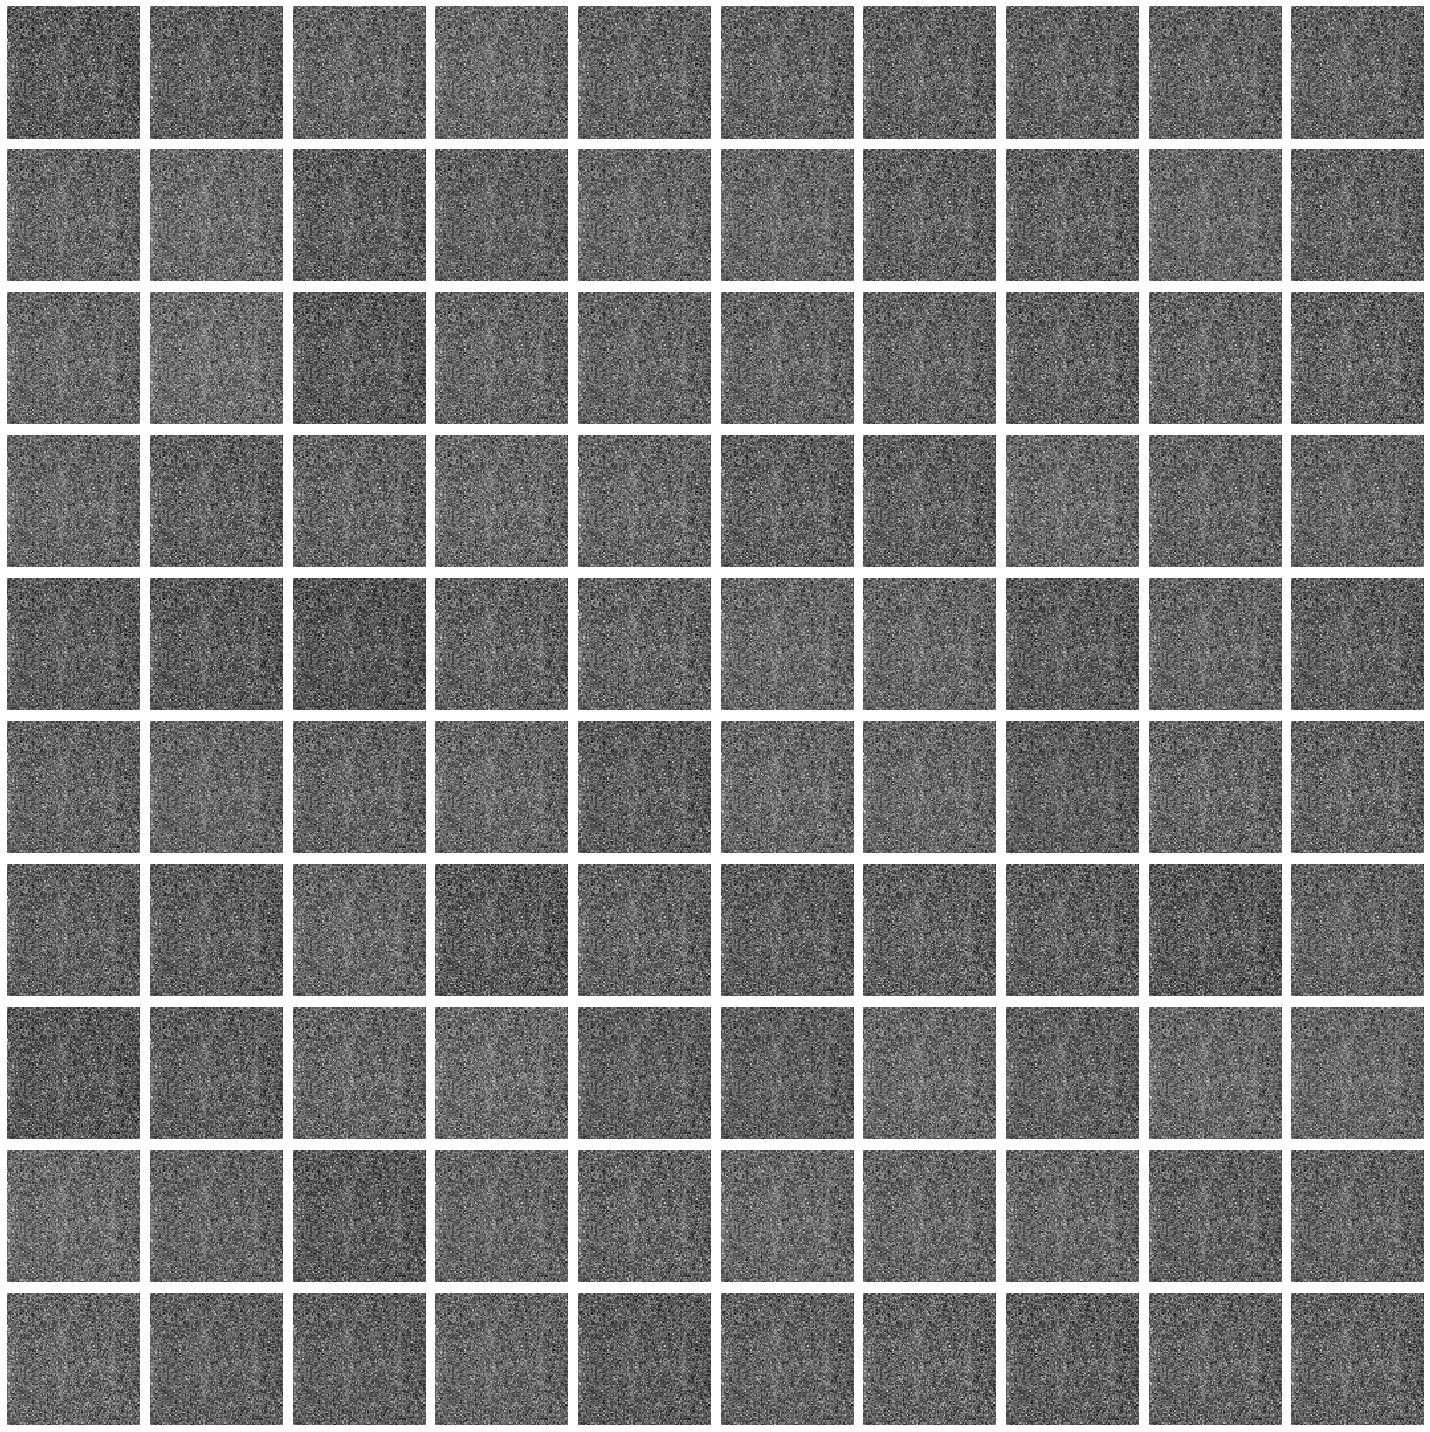

In [3]:
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    # x_train, y_train, x_test, y_test = load_minst_data() # x_train shape = (60000, 784)
    x_train = RandCirc(10000).np_gen_data
    # print(f'x_train[0] leng = {len(x_train[0])}') # 784 = 28*28
    # print(f'x_train leng = {len(x_train)}')       # 60k
    x_train = x_train.reshape(10000, 10000)
    print(f'x_train shape = {x_train.shape}')     # x_train shape = (100, 200, 400, 3) 
    # sys.exit()

    # Split the training data into batches of size 128
    batch_count = round(x_train.shape[0] / batch_size)

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(
                0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if 1:  # e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)


if __name__ == '__main__':
    train(500, 128)
